# GAM-based Pseudotime Testing

This notebook focuses on detecting genes whose expression changes significantly along pseudotime in single-cell RNA-seq data. To achieve this, we apply **Negative Binomial Generalized Additive Models (NB-GAMs)**, which are well-suited for modeling overdispersed count data and flexible nonlinear trends.

The workflow includes three steps, namely:
- Preprocessing: Single-cell expression data with an associated pseudotime trajectory.
- Modeling: Fitting NB-GAMs to capture smooth gene expression dynamics along pseudotime.
- Testing: Evaluating whether the smooth terms significantly deviate from zero, indicating dynamic regulation.


## Load libraries

In [4]:
import gamache as gm
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [5]:
adata = sc.datasets.paul15()

In [6]:
adata.layers["counts"] = adata.X.copy()
adata.raw = adata.copy()

## Preprocessing

In [7]:
sc.pp.recipe_zheng17(adata)

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_recipes.py:185: FutureWarning: Use sc.pp.highly_variable_genes instead
  filter_result = filter_genes_dispersion(


In [8]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.umap(adata)

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


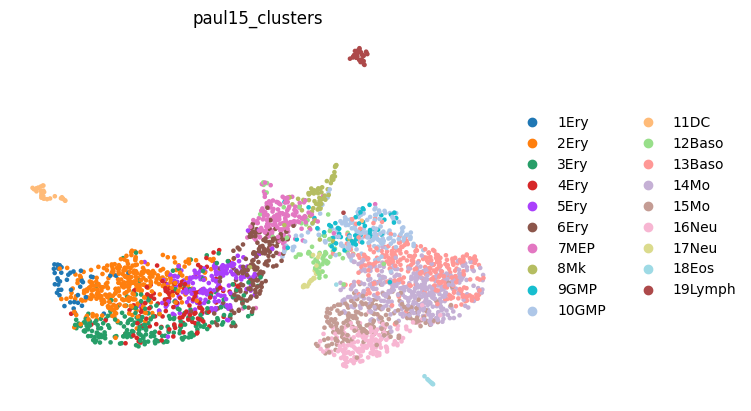

In [9]:
sc.pl.umap(adata, color=["paul15_clusters"], frameon=False)

In [10]:
# Subset to [1Ery, 2Ery, 3Ery, 4Ery, 5Ery, 6Ery, 7MEP, 8Mk]
adata = adata[
    adata.obs["paul15_clusters"].isin(
        ["1Ery", "2Ery", "3Ery", "4Ery", "5Ery", "6Ery", "7MEP", "8Mk"]
    ),
    :,
]

In [11]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.umap(adata)

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:385: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


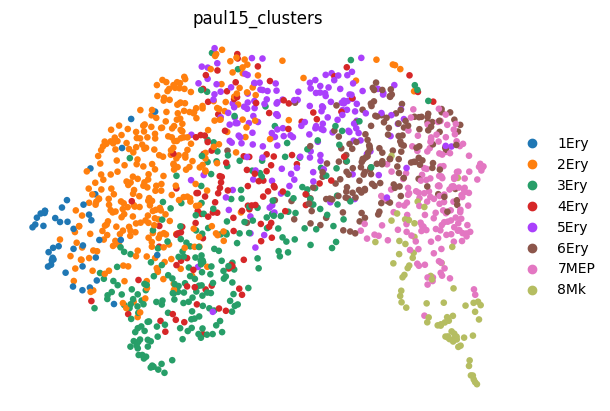

In [12]:
sc.pl.umap(adata, color=["paul15_clusters"], frameon=False)

In [13]:
sc.tl.diffmap(adata)

In [14]:
DC1 = [first[0] for first in adata.obsm["X_diffmap"]]
DC2 = [first[1] for first in adata.obsm["X_diffmap"]]
DC_tmp = [first[0] + first[1] for first in adata.obsm["X_diffmap"]]

adata.uns["iroot"] = np.argsort(DC_tmp)[-1]

sc.tl.dpt(adata)

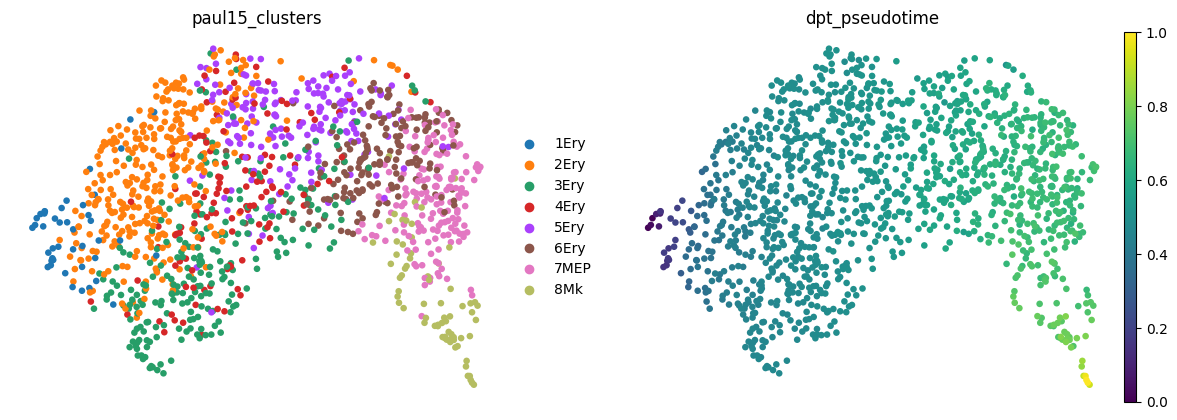

In [15]:
sc.pl.umap(adata, color=["paul15_clusters", "dpt_pseudotime"], frameon=False)

In [16]:
adata.write("paul15_endo.h5ad")

## Exclude lowly expressed genes

In [17]:
adata = sc.read("paul15_endo.h5ad")

# adata.X must contain raw counts for GAM fitting
adata = adata.raw.to_adata()

In [18]:
sc.pp.filter_genes(adata, min_cells=50)

## Fit the GAM model

We now fit a **Generalized Additive Model (GAM)** to the data.  
The hyperparameters can be tuned to improve the fit:

- **`lam`**: Regularization parameter that controls the amount of smoothing.  
  - Higher `lam` → smoother curve (less flexible).  
  - Lower `lam` → more flexible curve (risk of overfitting).

- **`df`**: Degrees of freedom, i.e. the number of basis functions.  
  - Higher `df` → more flexible fit.  
  - Lower `df` → smoother fit.

The choice of `lam` and `df` depends on the data and the desired balance between smoothness and flexibility.  
As a starting point, we use:

- `lam = 1`  
- `df = 8`

You are encouraged to experiment with different values to observe how they affect the resulting fit.


In [19]:
model = gm.tl.fit_gam(adata, lam=1, df=8)

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


## Assess Goodness of Fit

To measure how well the NB-GAM describes expression dynamics along pseudotime,  
we use the **proportion of deviance explained**.

- The **null model** assumes constant expression (a flat curve).  
- The **fitted model** explains variation by smoothing expression along pseudotime.  
- The metric is defined as:

$$D_{explained} = 1 - \frac{Deviance_{residual}}{Deviance_{null}}$$

Values range between 0 and 1:
- **0** → no improvement over the null model.  
- **1** → perfect fit to the data.  

If the deviance explained is **slightly negative**, it means the model fit is worse than the null, usually due to numerical noise or lack of signal.  
In practice, such values are often set to **0** and interpreted as “no improvement”.

In [20]:
# Get the deviance explained
gof_df = model.deviance_explained()
# Restrict to genes above zero
gof_df = gof_df[gof_df > 0]

/Users/adaml9/Code/github/gamache/src/gamache/tl/fit.py:374: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = self.adata.var[self.key + "_alpha"][gene]
/Users/adaml9/Code/github/gamache/src/gamache/tl/utils.py:132: RuntimeWarning: divide by zero encountered in log
  term1 = np.where(y > 0, y * np.log(y / mu), 0.0)
/Users/adaml9/Code/github/gamache/src/gamache/tl/utils.py:132: RuntimeWarning: invalid value encountered in multiply
  term1 = np.where(y > 0, y * np.log(y / mu), 0.0)
/Users/adaml9/Code/github/gamache/src/gamache/tl/fit.py:278: RuntimeWarning: overflow encountered in exp
  out = eta if type == "link" else np.exp(eta)
/Users/adaml9/Code/github/gamache/src/gamache/tl/utils.py:135: RuntimeWarning: divide by zero encountered in log
  term2 = (y + 1 / alpha) * np.log((y + 1 / alpha) / (mu +

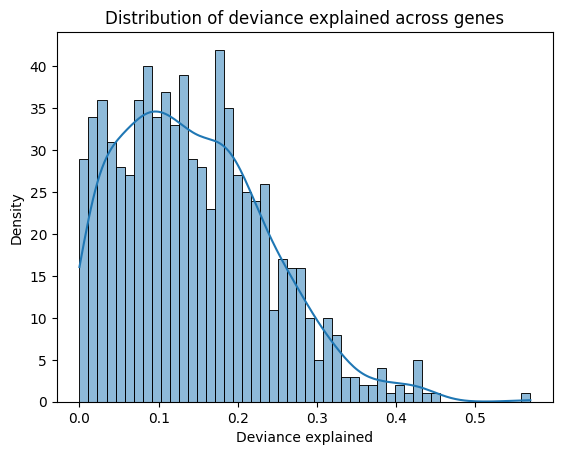

In [21]:
# Plot as a histogram
sns.histplot(gof_df, bins=50, kde=True)

plt.xlabel("Deviance explained")
plt.ylabel("Density")
plt.title("Distribution of deviance explained across genes")
plt.show()

## Test for association with pseudotime

In [ ]:
# Test all genes for association with pseudotime
results_df = model.test_all(test="association")

# Filter results for q-value < 0.05
results_df = results_df[results_df["qvalue"] < 0.05]

# Set gene as index
results_df = results_df.set_index("gene")

/Users/adaml9/Code/github/gamache/src/gamache/tl/fit.py:509: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nb_alpha = float(self.adata.var[self.key + "_alpha"][j])
/Users/adaml9/Code/github/gamache/src/gamache/tl/fit.py:509: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nb_alpha = float(self.adata.var[self.key + "_alpha"][j])
/Users/adaml9/Code/github/gamache/src/gamache/tl/fit.py:509: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n

/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/Users/adaml9/Code/github/gamache/.venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: ove

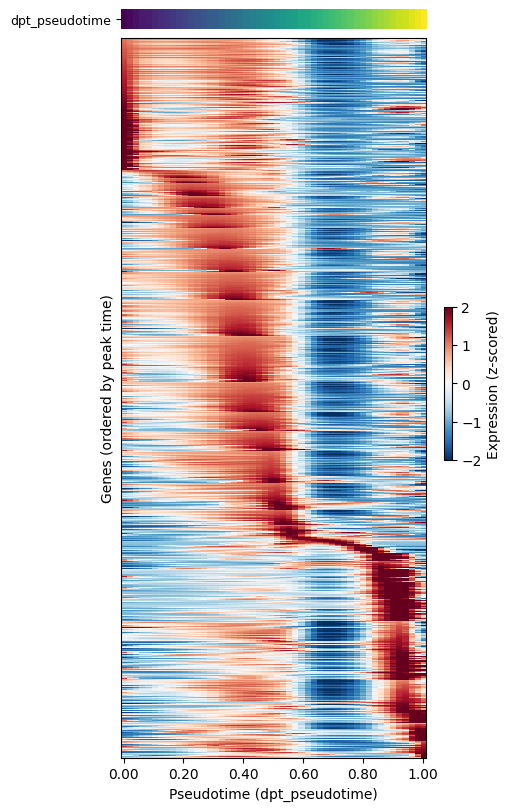

In [23]:
gm.pl.plot_gene_heatmap(adata, list(results_df.index), cmap="RdBu_r", show_gene_labels=None, model=model, figsize=(5,8))

In [ ]:
# Obtain significant genes with good model fit
results_df.join(gof_df, on="gene", how="left").sort_values("deviance_explained", ascending=False)

,statistic,pvalue,qvalue,n_detected,edf,alpha,center_of_mass,t_peak,mean_fitted,deviance_explained
gene,,,,,,,,,,
Sphk1,2.885861e+04,0.0,0.0,873,6.713268,1.0,0.342259,0.393801,2.290710,0.569275
Pklr,4.306872e+06,0.0,0.0,718,7.039644,1.0,0.295771,0.335194,1.177940,0.450007
Mthfd1,2.886220e+04,0.0,0.0,1024,6.761183,1.0,0.379538,0.491478,2.796043,0.439464
Ccne1,4.526715e+04,0.0,0.0,673,6.936776,1.0,0.289127,0.325427,1.340928,0.428501
Ank1,3.573550e+04,0.0,0.0,651,6.787623,1.0,0.308348,0.364498,1.129576,0.425159
...,...,...,...,...,...,...,...,...,...,...
mFLJ00022,6.026160e+04,0.0,0.0,378,6.973272,1.0,0.697553,0.921259,0.842664,NaN
mKIAA0569,1.386675e+04,0.0,0.0,292,6.775940,1.0,0.654041,0.935911,0.490653,NaN
mKIAA1027,4.576334e+04,0.0,0.0,1121,6.840276,1.0,0.577644,0.896840,3.912075,NaN


(<Figure size 913x480 with 1 Axes>,
 <Axes: title={'center': 'Fit for Sphk1'}, xlabel='Pseudotime', ylabel='Expression Sphk1'>)

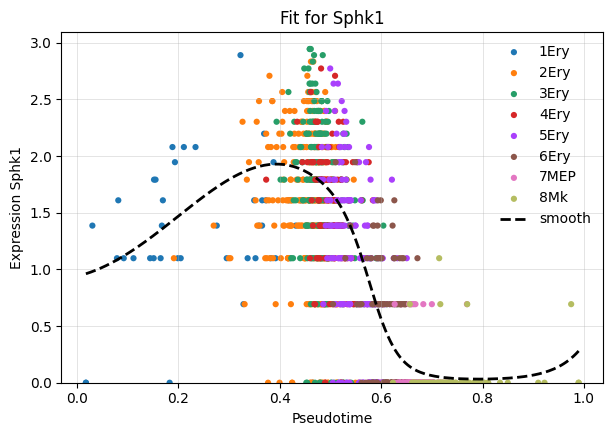

In [33]:
gm.pl.plot_gene_fit(model, "Sphk1", color="paul15_clusters", scatter_size=80)